In [1]:
import boto3
from langchain_aws import ChatBedrock
from botocore.config import Config
import warnings
warnings.filterwarnings("ignore")

region = "us-west-2"
config = Config(
    region_name=region,
    signature_version = "v4",
    retries={
        "max_attempts":3,
        "mode" : "standard",
    }
)
bedrock_rt = boto3.client("bedrock-runtime", config=config)

model_id = "anthropic.claude-3-sonnet-20240229-v1:0"

model_kwargs = {
    "max_tokens" : 4096,
    "temperature" : 0.0,
    "stop_sequences" : ["Human"],
}

llm = ChatBedrock(
    client = bedrock_rt,
    model_id = model_id,
    model_kwargs = model_kwargs,
)

In [12]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
    FunctionMessage,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph, START


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful AI assistant, collaborating with other assistants."
                " Use the provided tools to progress towards answering the question."
                " If you are unable to fully answer, that's OK, another assistant with different tools "
                " will help where you left off. Execute what you can to make progress."
                " If you or any of the other assistants have the final answer or deliverable,"
                " prefix your response with FINAL ANSWER so the team knows to stop."
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name= "messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_tools(tools)

In [5]:
import operator
from typing import Annotated,Sequence,TypedDict
from langgraph.graph import END,StateGraph,START
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage],operator.add]

In [6]:
def summarizer(state):
    messages = state['messages']
    git_diff = messages[0]
    prompt = "Your task is to provide a summary of the git diff provided in a concise manner. Following is the git diff : {git_diff}"
    response = llm.invoke(prompt)
    return {"messages" : [response]}

def reviewer(state):
    messages = state['messages']
    git_diff = messages[0]
    prompt = "Your task is to provide review of the code written,point out potential risks and suggest improvements in a concise manner. Following is the git diff: {git_diff}"
    response = llm.invoke(prompt)
    return {"messages": [response]}


In [7]:
from langgraph.graph import StateGraph

workflow = StateGraph(AgentState)

workflow.add_node("Summarizer",summarizer)
workflow.add_node("Reviewer",reviewer)

workflow.add_edge('Summarizer','Reviewer')

workflow.set_entry_point("Summarizer")
workflow.set_finish_point("Reviewer")

app = workflow.compile()

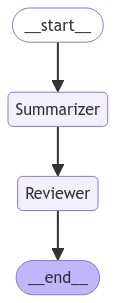

In [8]:
from IPython.display import Image,display

display(Image(app.get_graph(xray = True).draw_mermaid_png()))

In [14]:
events = app.stream(
    {
        "messages": [
            HumanMessage(
                content="""
                diff --git a/README.md b/README.md
index 28e5da8..68e3474 100644
--- a/README.md
+++ b/README.md
@@ -1,2 +1 @@
-# research-agent
-It is a multi-agent workflow that uses langgraph library.
+# research-agent
\ No newline at end of file

                """
            )
        ],
    },
    {"recursion_limit": 10},
)
for s in events:
    print(s)
    print("----")

{'Summarizer': {'messages': [AIMessage(content='Unfortunately, you did not provide the actual `git diff` output. However, I can explain how to interpret a `git diff` once you provide the output.\n\nA `git diff` command shows the differences between two commits, branches, or the working directory and the staging area. The output typically displays the following information:\n\n1. **File Changes**: The names of the files that have been modified, added, or deleted.\n\n2. **Line Changes**: For each modified file, the output shows the lines that have been added, removed, or changed. Added lines are prefixed with a `+`, removed lines are prefixed with a `-`, and unchanged lines have no prefix.\n\n3. **Chunk Headers**: Each set of changes is separated by a "chunk header" that provides context about the location of the changes within the file.\n\nThe summary should concisely describe the nature of the changes, such as:\n\n- Files added, modified, or deleted\n- Brief descriptions of the signifi